In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, boxcox_normmax
from scipy import stats
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
df_raw = pd.read_csv('data.csv')

In [3]:
# Peak at data structure
df_raw.head()

,Zip,Geoname,Topcode,Lowpop,N_Hcwork_Rt,N_Ed_Lths,N_Ed_Hs,N_Ed_Col,N_Unemp,N_Bluecol,...,Hf_Env_Rank,Hf_Ses_Rank,Hf_Rank,Ho_Mort_Rank,Ho_Qol_Rank,Ho_Rank,Ho_Quintile,Hf_Quintile,HF_HO_Comb,Comb_Rank
0,63005,Chesterfield,0,0,49.994389,0.007743,0.072048,0.920209,0.027312,0.121447,...,75,2,2,115,55,2,1,1,-4.108125,2
1,63010,Arnold,0,0,27.814827,0.124750,0.327809,0.547440,0.068028,0.415388,...,496,160,209,478,695,219,2,2,-0.555916,214
2,63011,Ballwin,0,0,44.114921,0.044197,0.146620,0.809183,0.036756,0.194085,...,181,22,23,130,160,22,1,1,-2.229820,23
3,63012,Barnhart,0,0,38.634659,0.067996,0.302977,0.629028,0.059055,0.415969,...,388,102,102,466,393,114,1,1,-0.995193,108
4,63013,Beaufort,0,0,17.462165,0.053643,0.437150,0.509207,0.075423,0.634318,...,292,315,193,125,106,171,1,2,-0.660696,178


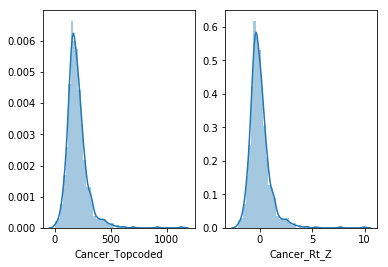

In [4]:
# looking for a target variable, cancer is a compelling choice.
# There are two cancer variables. Let's see how they compare.
plt.subplot(121)
sns.distplot(df_raw['Cancer_Topcoded']);
plt.subplot(122)
sns.distplot(df_raw['Cancer_Rt_Z']);

In [5]:
# They look to be the same, except cancer_rt_z is scaled (z-score). 
# Let's remove it from the dataset since we will scale the data on our own anyway.
df = df_raw.drop('Cancer_Rt_Z', axis=1);

In [6]:
# View some information about the cancer variable.
df['Cancer_Topcoded'].describe()

count     940.000000
mean      197.700047
std        92.041998
min         5.188067
25%       143.912132
50%       181.963161
75%       232.170684
max      1134.538153
Name: Cancer_Topcoded, dtype: float64

In [7]:
# There looks to be some skewness to this variable. Let's check that and kurtosis.
print("Skewness: %f" % df['Cancer_Topcoded'].skew())
print("Kurtosis: %f" % df['Cancer_Topcoded'].kurt())

Skewness: 2.646793
Kurtosis: 17.235690


In [8]:
# Now let's try to pare down the number of variables to reduce redundancy and improve our visualizations.
# It looks like many variables have an "_z" and "topcoded" version. Let's remove the z-scored duplicates.
tag = '_Z'
rt_z_cols = df.filter(like=tag, axis=1).columns
df = df.drop(rt_z_cols, axis=1)
print('Dataframe shape:', df.shape)

Dataframe shape: (940, 102)


In [9]:
# Down to 117 columns. Let's see how many counties have a 'low population' and consider removing them from analysis later.
print(f"Low population counties: {len(df[df['Lowpop']==1])/len(df) * 100:.2f}%")

Low population counties: 11.38%


In [10]:
# Let's look for other columns we might get rid of.
# Delete combined scores as well as zip code and county names.
tags = ['Rank', 'Quintile', 'Zip', 'Geoname']
for tag in tags:
    rt_z_cols = df.filter(like=tag, axis=1).columns
    df = df.drop(rt_z_cols, axis=1)
print('Dataframe shape:', df.shape)

Dataframe shape: (940, 89)


In [11]:
df.columns

Index(['Topcode', 'Lowpop', 'N_Hcwork_Rt', 'N_Ed_Lths', 'N_Ed_Hs', 'N_Ed_Col',
       'N_Unemp', 'N_Bluecol', 'N_Rent', 'N_Home_Val', 'N_Vacant', 'N_Kid_Pov',
       'N_Med_Hhy', 'N_Y_Neqal', 'N_Nonengl', 'N_Unmarry', 'N_Hhsize',
       'N_Sing_Mom', 'Nprem_Deaths_Topcoded', 'Ypll_Topcoded',
       'Low_Bwt_Topcoded', 'Psych_Topcoded', 'Smoke_Topcoded',
       'Obese_Topcoded', 'Substance_Topcoded', 'Teen_Preg_Topcoded',
       'Sti_Topcoded', 'Assault_Dx_Topcoded', 'Injur_Mort_Topcoded',
       'Mcaid_Topcoded', 'Unins_Topcoded', 'Hirisk_Mamm_Topcoded',
       'Copd_Topcoded', 'Stroke_Topcoded', 'Diabetes_Topcoded',
       'Hyperten_Topcoded', 'Arthjoint_Topcoded', 'Kidney_Topcoded',
       'Heartdis_Topcoded', 'Liverdis_Topcoded', 'Atheroscler_Topcoded',
       'Asthma_Topcoded', 'Cancer_Topcoded', 'Cancoth_Topcoded',
       'Breastcan_Topcoded', 'Lungcan_Topcoded', 'Lymphcan_Topcoded',
       'Malegencan_Topcoded', 'Femalegencan_Topcoded', 'Skincan_Topcoded',
       'Urinarycan_Topc

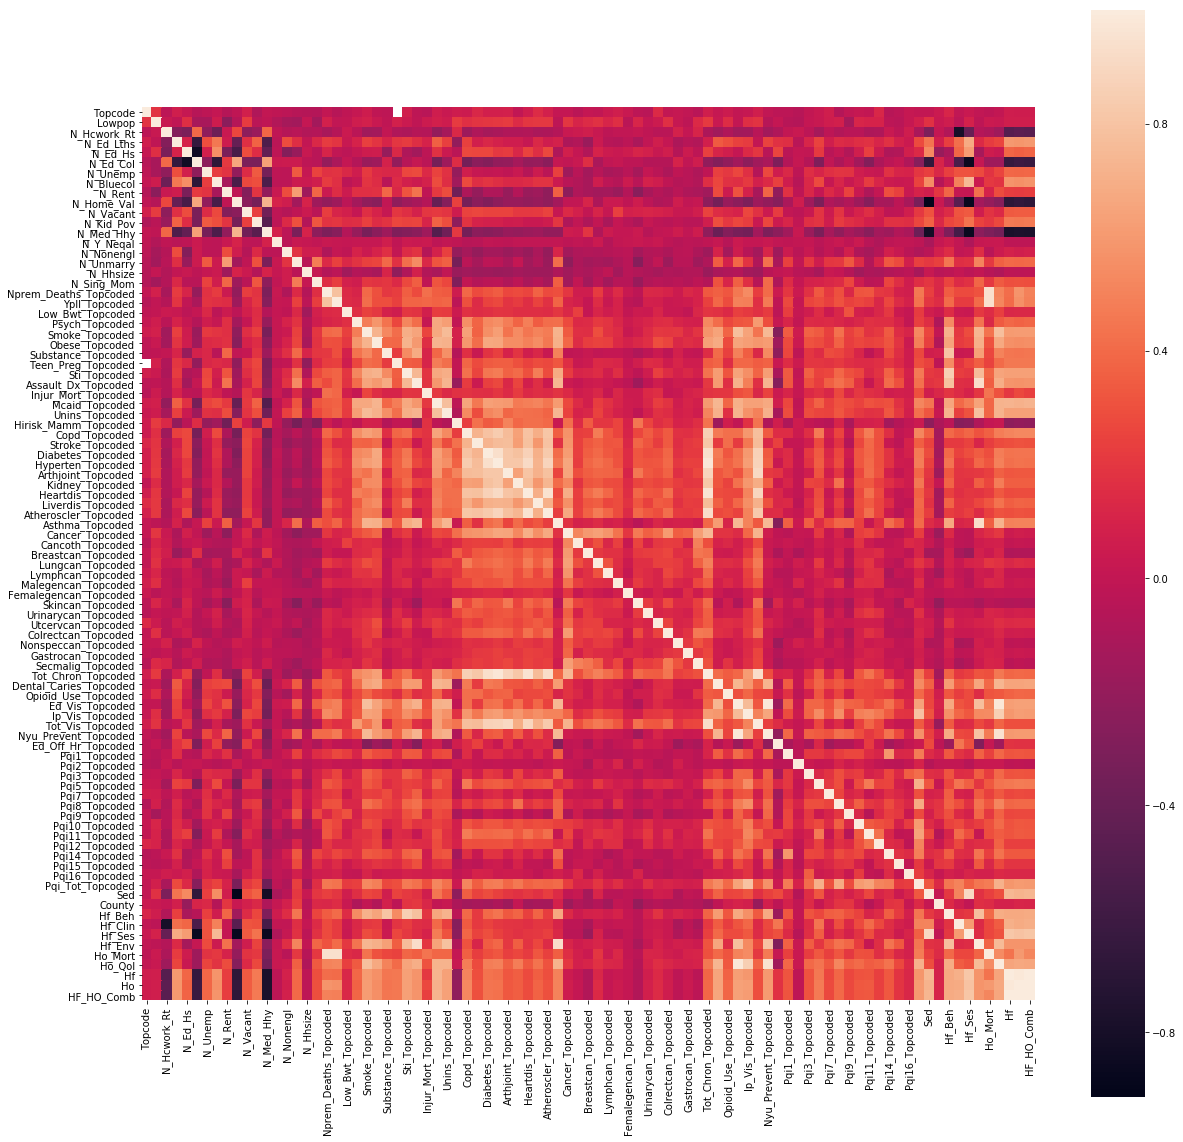

In [12]:
# We're down to 89 columns. Now let's start to visualize our data.
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, square=True);

In [13]:
df['Breastcan_Topcoded'].describe()

count    939.000000
mean      82.624469
std       54.695036
min        0.000000
25%       51.301595
50%       72.432171
75%      101.545139
max      433.333333
Name: Breastcan_Topcoded, dtype: float64

In [14]:
df['Breastcan_Topcoded'] = df['Breastcan_Topcoded'].fillna(df['Breastcan_Topcoded'].median())

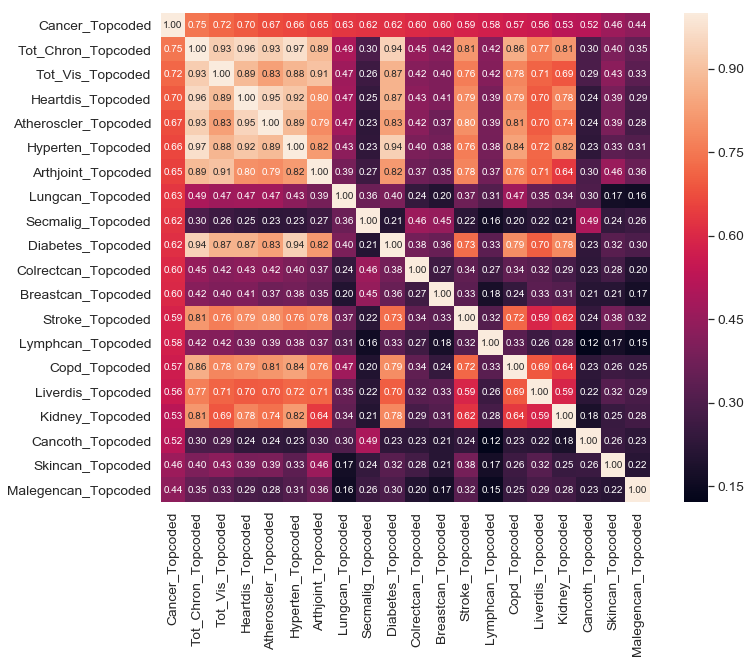

In [15]:
# The heatmap still has a lot going on. Let's just look at the 20 variables most correlating with cancer.
num_variables = 20
cols = corrmat.nlargest(num_variables, 'Cancer_Topcoded')['Cancer_Topcoded'].index
coefs = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hmap = sns.heatmap(coefs, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                   yticklabels=cols.values , xticklabels=cols.values)
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


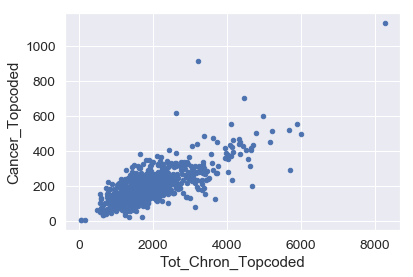

In [16]:
# Let's look at some scatter plots of individual variables versus our cancer target
var = 'Tot_Chron_Topcoded'
data = pd.concat([df['Cancer_Topcoded'], df[var]], axis=1)
data.plot.scatter(x=var, y='Cancer_Topcoded');

In [17]:
# Let's take a look at some other data from that very high value location.
df_raw[df_raw['Tot_Chron_Topcoded'] > 8000]

,Zip,Geoname,Topcode,Lowpop,N_Hcwork_Rt,N_Ed_Lths,N_Ed_Hs,N_Ed_Col,N_Unemp,N_Bluecol,...,Hf_Env_Rank,Hf_Ses_Rank,Hf_Rank,Ho_Mort_Rank,Ho_Qol_Rank,Ho_Rank,Ho_Quintile,Hf_Quintile,HF_HO_Comb,Comb_Rank
443,64438,Darlington,0,1,12.048193,0.113475,0.560284,0.326241,0.0,0.285714,...,896,585,870,924,887,899,5,5,1.357728,884


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


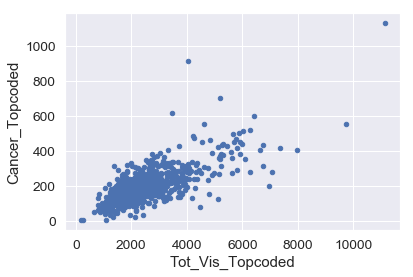

In [18]:
# A web search shows that this village had only 121 people in 2010. 
# This may get removed from the dataset along with the rest of the low population areas depending on our analysis later.
# Let's look at some other variables' relationships with cancer.
var = 'Tot_Vis_Topcoded'
data = pd.concat([df['Cancer_Topcoded'], df[var]], axis=1)
data.plot.scatter(x=var, y='Cancer_Topcoded');

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


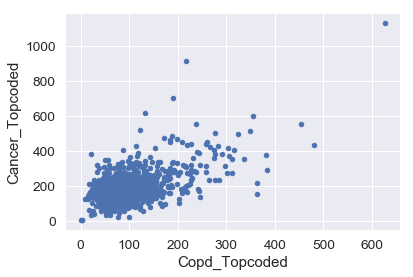

In [19]:
var = 'Copd_Topcoded'
data = pd.concat([df['Cancer_Topcoded'], df[var]], axis=1)
data.plot.scatter(x=var, y='Cancer_Topcoded');

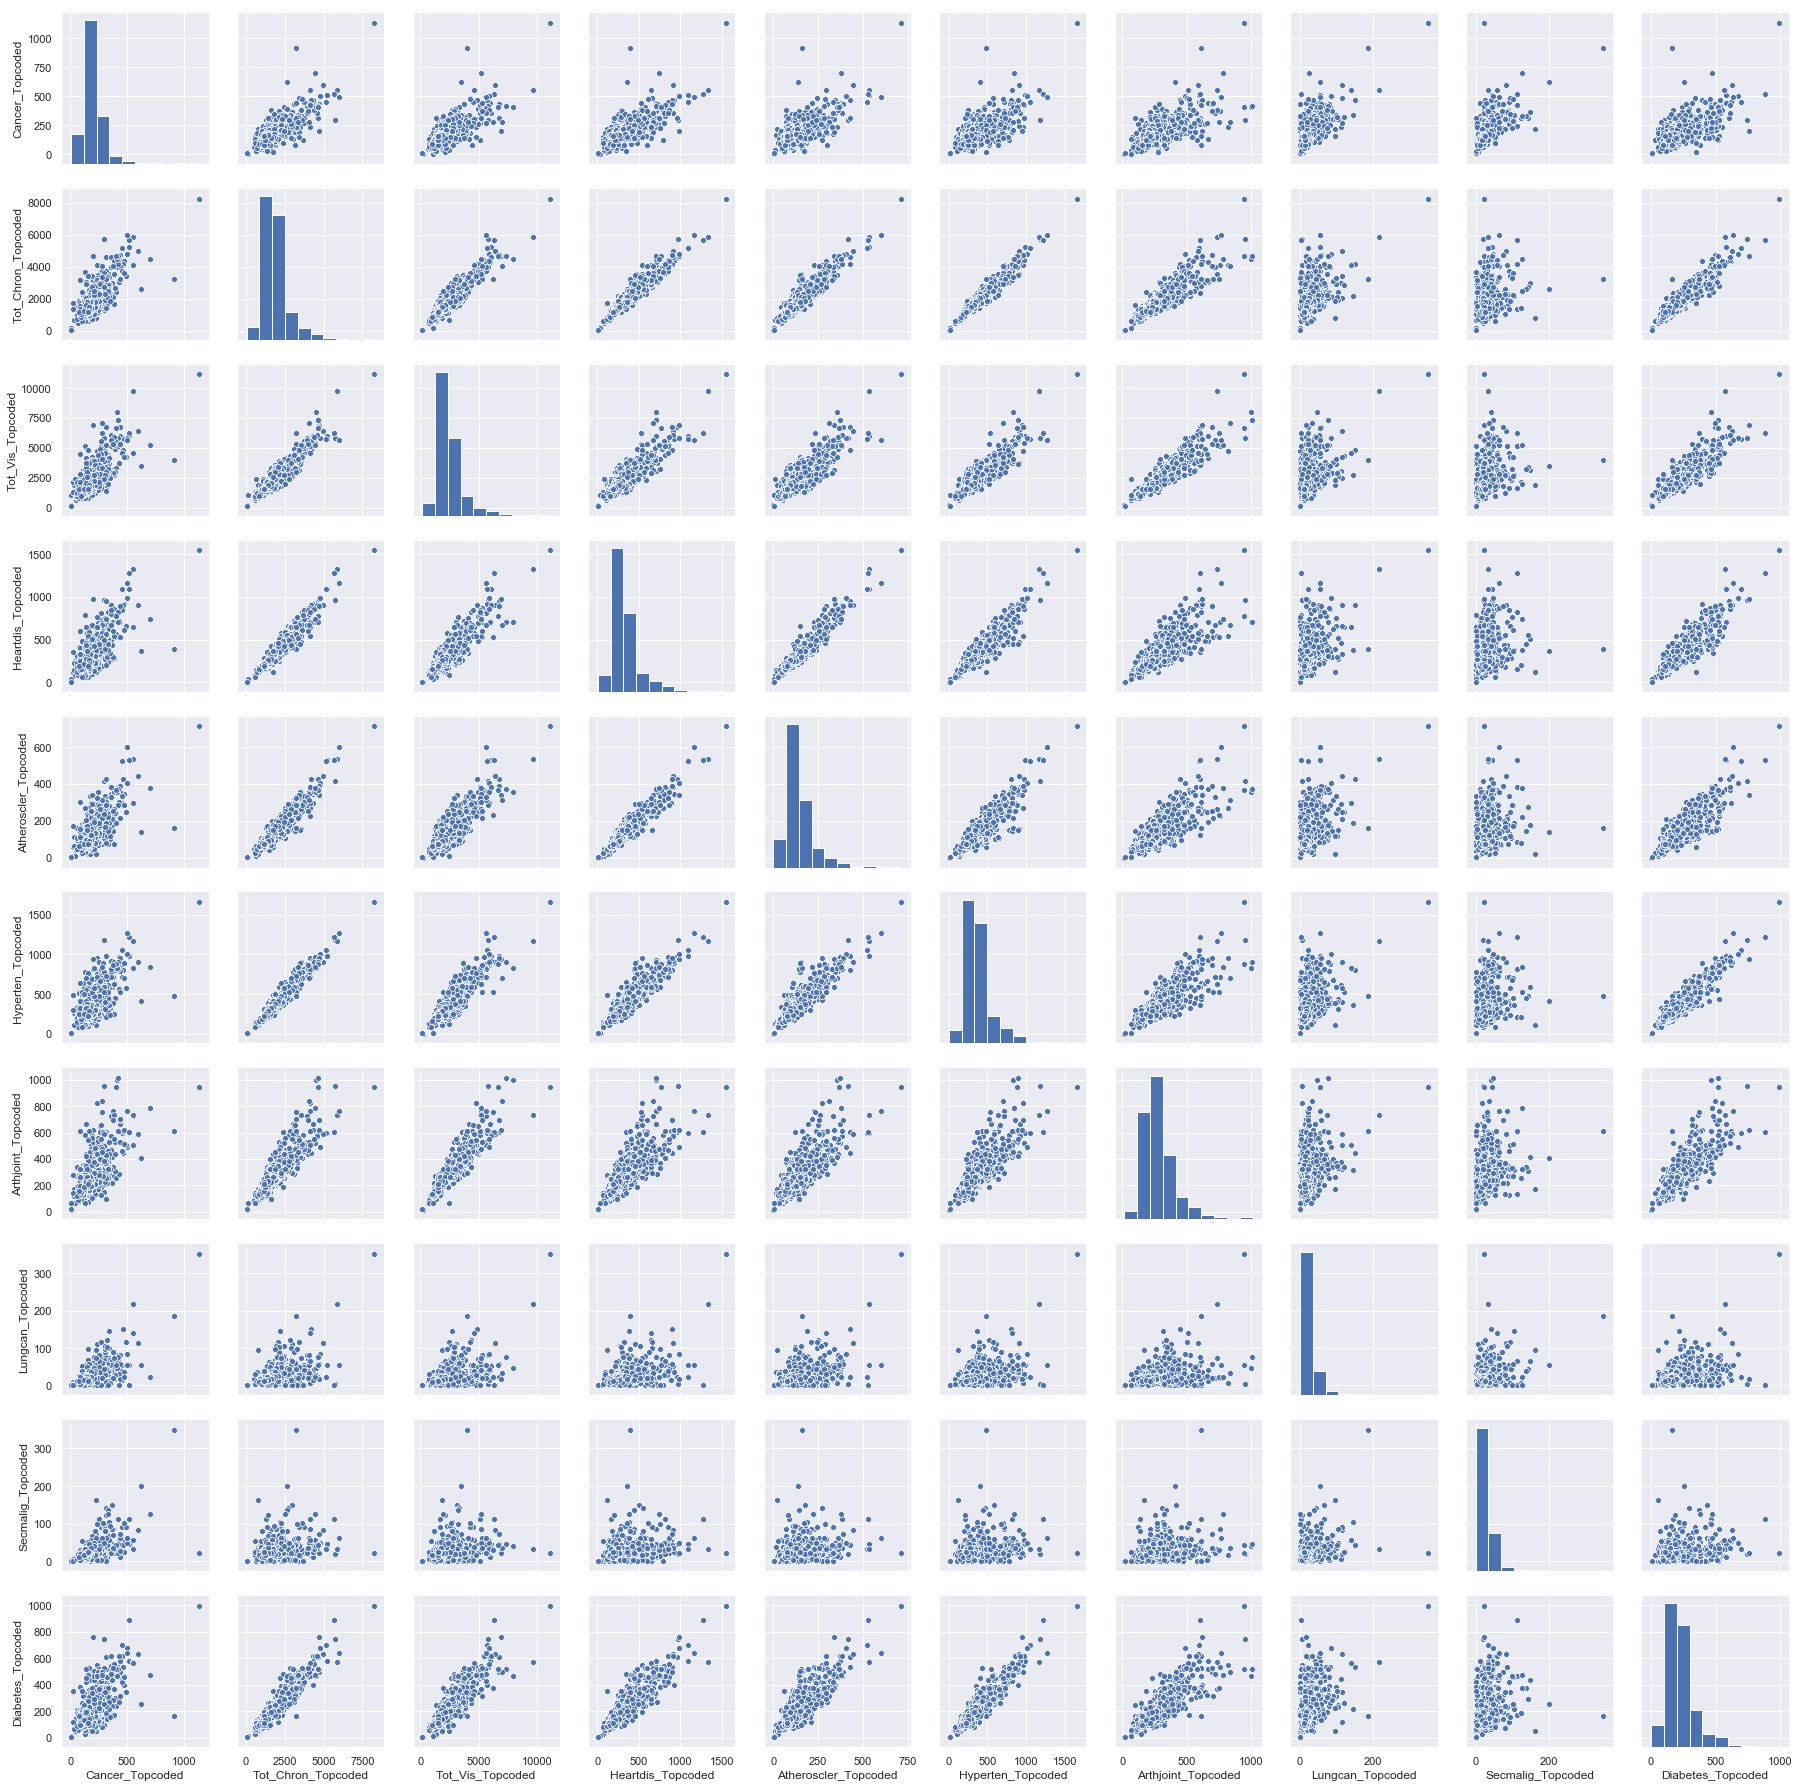

In [20]:
# Let's look at a pair plot of the 10 variables above
sns.set()
sns.pairplot(df[cols[:10]], size = 2.5)
plt.show();

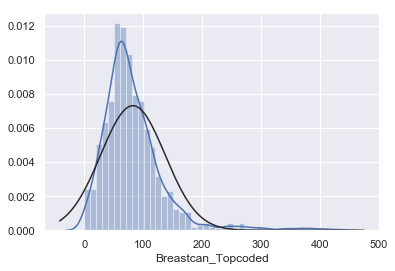

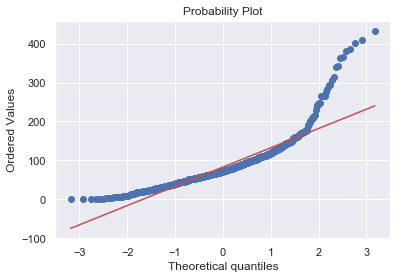

In [21]:
# We see some strikingly strong correlations, such as tot_chron vs. hyperten. We also see that these variable exhibit the same skewness as the cancer variable above.
# Let's standardize the data to take care of that.
# First, let's visualize the histogram and probability plot for our target variable as an example.
sns.distplot(df['Breastcan_Topcoded'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Breastcan_Topcoded'], plot=plt)

In [22]:
df['Breastcan_Topcoded'].describe()

count    940.000000
mean      82.613626
std       54.666915
min        0.000000
25%       51.311366
50%       72.432171
75%      101.536458
max      433.333333
Name: Breastcan_Topcoded, dtype: float64

In [26]:
df[df['Breastcan_Topcoded']<1]['Breastcan_Topcoded'] = 1

In [27]:
df['Breastcan_Topcoded'].describe()

count    940.000000
mean      82.613626
std       54.666915
min        0.000000
25%       51.311366
50%       72.432171
75%      101.536458
max      433.333333
Name: Breastcan_Topcoded, dtype: float64

In [29]:
df['Breastcan_Topcoded'] = boxcox1p(df['Breastcan_Topcoded'], boxcox_normmax(df['Breastcan_Topcoded'] + 1))

In [30]:
df['Breastcan_Topcoded'].describe()

count    940.000000
mean      10.092791
std        2.901175
min        0.000000
25%        8.610307
50%       10.064202
75%       11.675661
max       21.305323
Name: Breastcan_Topcoded, dtype: float64

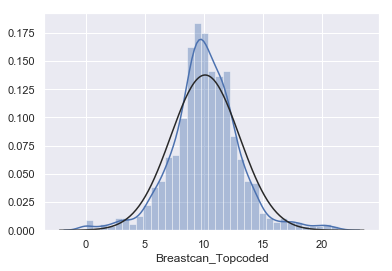

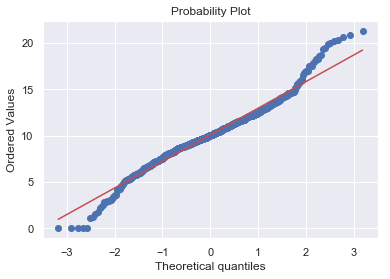

In [31]:
sns.distplot(df['Breastcan_Topcoded'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Breastcan_Topcoded'], plot=plt)

In [34]:
df.columns[1]

'Lowpop'

In [36]:
df = df.drop('Topcode', axis=1)